In [1]:
!pip install yfinance

In [2]:
import yfinance as yf

# Fetch Tesla stock data
tesla = yf.Ticker("TSLA")

# Get historical data (adjust the start and end dates as needed)
tesla_data = tesla.history(start="2023-01-01", end="2023-12-18")


{'address1': '1 Tesla Road', 'city': 'Austin', 'state': 'TX', 'zip': '78725', 'country': 'United States', 'phone': '512 516 8177', 'website': 'https://www.tesla.com', 'industry': 'Auto Manufacturers', 'industryKey': 'auto-manufacturers', 'industryDisp': 'Auto Manufacturers', 'sector': 'Consumer Cyclical', 'sectorKey': 'consumer-cyclical', 'sectorDisp': 'Consumer Cyclical', 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. It operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehicle sales, a network of Tesla Superchargers, and in-app upg

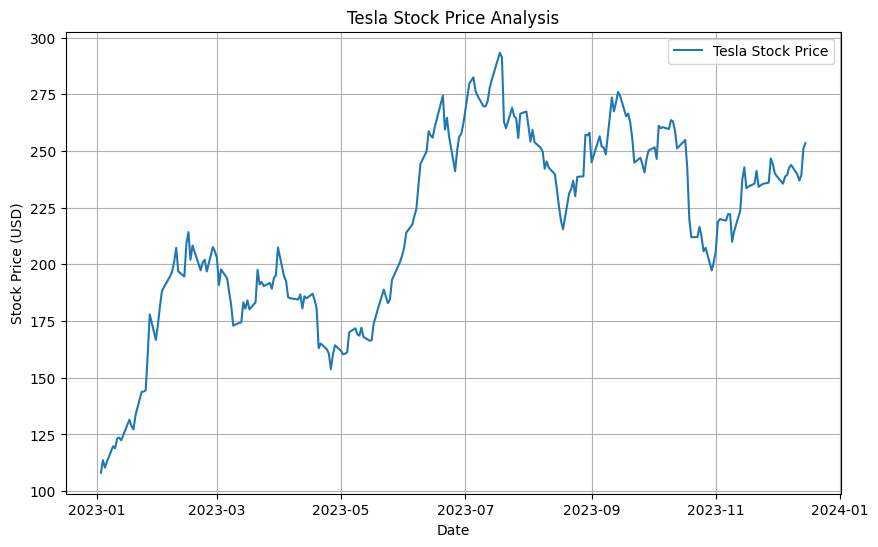

In [3]:
import matplotlib.pyplot as plt

# Display basic information about the stock
print(tesla.info)

# Plot historical stock prices
plt.figure(figsize=(10, 6))
plt.plot(tesla_data['Close'], label='Tesla Stock Price')
plt.title('Tesla Stock Price Analysis')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid()
plt.show()


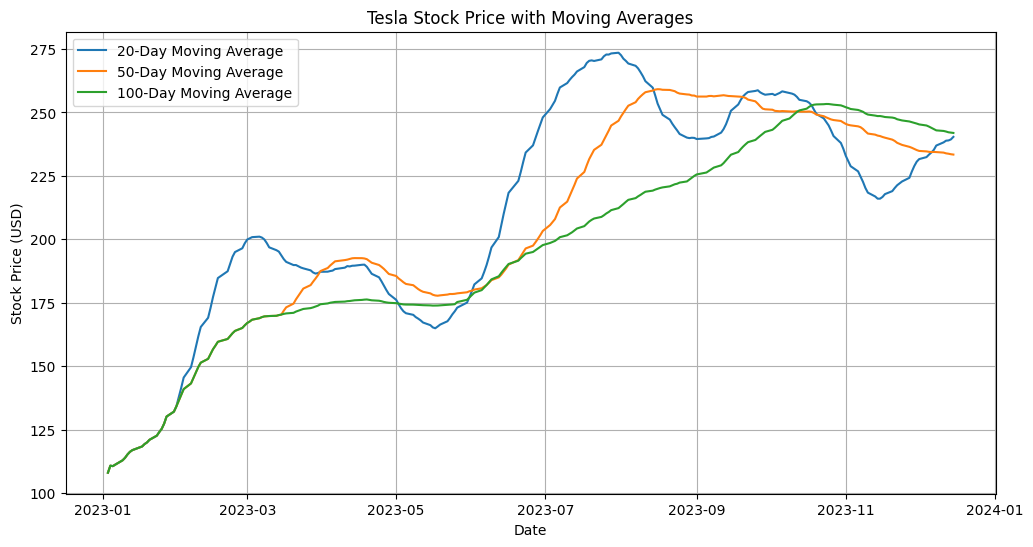

In [5]:
# Calculate moving averages (e.g., 50-day and 200-day)
short_window = 20
medium_window = 50
long_window = 100

tesla_data['Short_MA'] = tesla_data['Close'].rolling(window=short_window, min_periods=1).mean()
tesla_data['Medium_MA'] = tesla_data['Close'].rolling(window=medium_window, min_periods=1).mean()
tesla_data['Long_MA'] = tesla_data['Close'].rolling(window=long_window, min_periods=1).mean()

# Plotting the stock prices and moving averages
plt.figure(figsize=(12, 6))
# plt.plot(tesla_data['Close'], label='Tesla Stock Price')
plt.plot(tesla_data['Short_MA'], label=f'{short_window}-Day Moving Average')
plt.plot(tesla_data['Medium_MA'], label=f'{medium_window}-Day Moving Average')
plt.plot(tesla_data['Long_MA'], label=f'{long_window}-Day Moving Average')

plt.title('Tesla Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid()
plt.show()


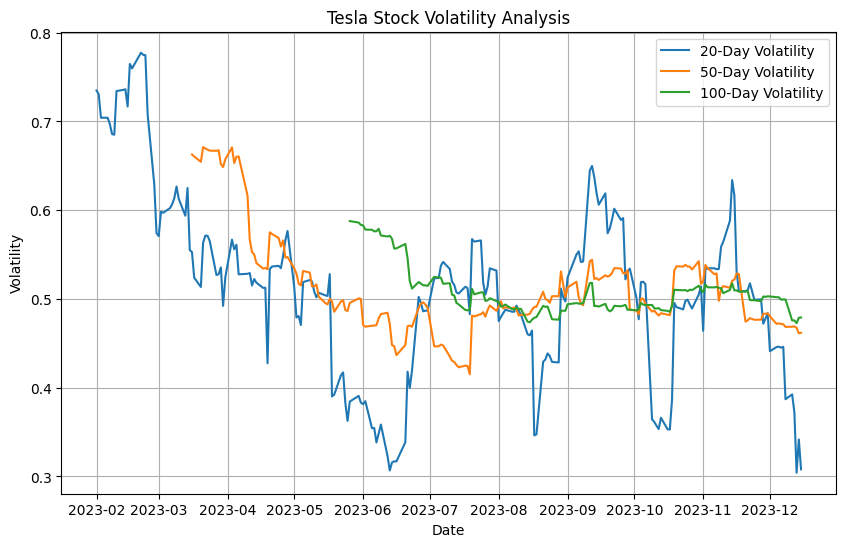

In [6]:
# Calculate daily returns
tesla_data['Daily_Return'] = tesla_data['Close'].pct_change()

# Calculate rolling standard deviation for different periods (20, 50, and 100 days)
rolling_periods = [20, 50, 100]

plt.figure(figsize=(10, 6))

for period in rolling_periods:
    rolling_volatility = tesla_data['Daily_Return'].rolling(window=period).std() * (252 ** 0.5)  # Annualized volatility
    plt.plot(rolling_volatility, label=f'{period}-Day Volatility')

plt.title('Tesla Stock Volatility Analysis')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()


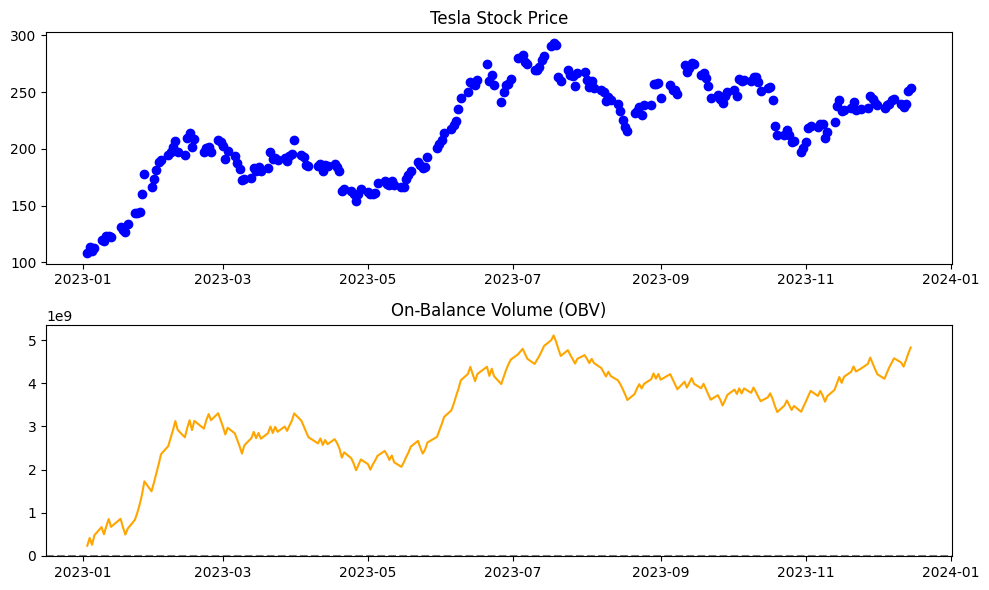

In [11]:
import pandas as pd
import numpy as np
# Calculate daily OBV
tesla_data['Daily_Return'] = tesla_data['Close'].pct_change().fillna(0)
tesla_data['Direction'] = np.where(tesla_data['Daily_Return'] >= 0, 1, -1)
tesla_data['Volume_Direction'] = tesla_data['Volume'] * tesla_data['Direction']
tesla_data['OBV'] = tesla_data['Volume_Direction'].cumsum()

# Plotting OBV and Volume
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.scatter(tesla_data.index, tesla_data['Close'], color='blue', marker='o')
plt.title('Tesla Stock Price')

plt.subplot(2, 1, 2)
plt.plot(tesla_data['OBV'], label='On-Balance Volume', color='orange')
plt.title('On-Balance Volume (OBV)')
plt.axhline(y=0, color='gray', linestyle='--')  # Adding zero line for reference

plt.tight_layout()
plt.show()


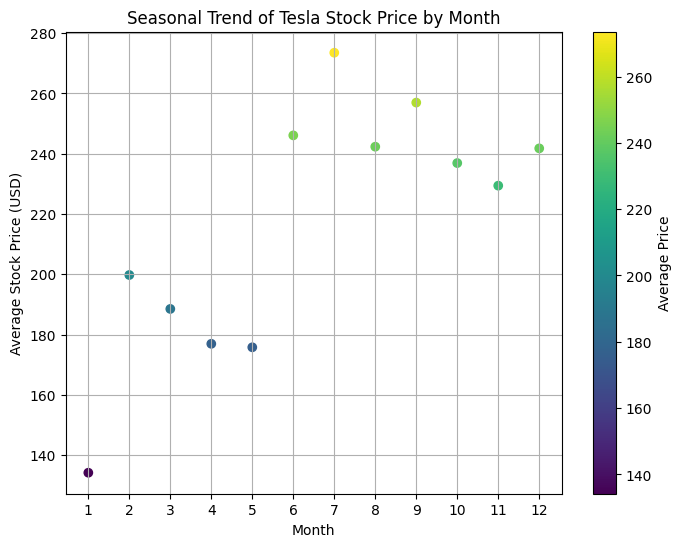

In [13]:
# Extract month from the date index
tesla_data['Month'] = tesla_data.index.month

# Calculate average stock price for each month
monthly_average = tesla_data.groupby('Month')['Close'].mean()

# Plotting the seasonal trend scatter plot based on months
plt.figure(figsize=(8, 6))
plt.scatter(monthly_average.index, monthly_average.values, marker='o', c=monthly_average.values, cmap='viridis')

plt.title('Seasonal Trend of Tesla Stock Price by Month')
plt.xlabel('Month')
plt.ylabel('Average Stock Price (USD)')
plt.xticks(range(1, 13))  # Set x-axis ticks to represent months (1-12)
plt.colorbar(label='Average Price')
plt.grid()
plt.show()
